# Newton's Method

## Introduction

In this blog post, I modified the code from my logistic regression blog post to include an implementation of Newton's Method for logistic regression. This involves the creation of a Hessian matrix, a computation of the second derivatives of the loss function. After this I experiment on the model, comparing it to the standard form of gradient descent optimization. These experiments include checking for α values in which the model using Newton's method converges at a low loss value significantly faster. Additionally, I look for values of α where the model fails to converge. I then analyze the operation size of each optimization method, comparing when each method should be used.

### Source Code
https://github.com/jblake05/jblake05.github.io/blob/main/posts/newton-optimizer/logistic.py

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
import numpy as np
import matplotlib.pyplot as plt

First, I create the data needed for the experiments using the classification_data function from the LinearRegression assignment. This creates linearly inseparable, noisy data (in this case in two dimensions).

In [4]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

## Graphing Functions

Next, I used the graphing functions from the linear regression assignment (adapted from the perceptron lecture). This includes functions one to plot data, draw lines for decision boundaries, plot the decision boundaries, and plot the loss values.

The plot_data function places two-dimensional data on a graph, using markers to dillineate data points with different target values.

In [5]:
# from perceptron lecture

def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

Next, the draw_line function plots the model's weight across a 2D plane.

In [6]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

plot_decisions uses the previous two functions to plot the first 5 and last 5 iterations of a training loop based on the parameterized weight and loss vectors. In the process, it labels the graph with the loss the respective weight achieves.

In [7]:
# plots the first and last 5 iterations of the decision boundary
def plot_decisions(X, y, weight_vec, loss_vec):
        # set up the figure
        current_ax = 0
        plt.rcParams["figure.figsize"] = (10, 8)
        fig, axarr = plt.subplots(2, 5, sharex = True, sharey = True)

        # iter through weight_vec

        for i in range(5):
                ax = axarr.ravel()[current_ax]
                plot_data(X, y, ax)
                draw_line(weight_vec[i], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
                draw_line(weight_vec[i+1], x_min = -1, x_max = 2, ax = ax, color = "black")
                ax.set_title(f"loss = {loss_vec[i]:.3f}")
                ax.set(xlim = (-1, 2), ylim = (-1, 2))
                current_ax += 1
        
        for i in range(len(weight_vec) - 6, len(weight_vec) - 1):
                ax = axarr.ravel()[current_ax]
                plot_data(X, y, ax)
                draw_line(weight_vec[i], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
                draw_line(weight_vec[i+1], x_min = -1, x_max = 2, ax = ax, color = "black")
                ax.set_title(f"loss = {loss_vec[i]:.3f}")
                ax.set(xlim = (-1, 2), ylim = (-1, 2))
                current_ax += 1
        fig.suptitle("LR Decision Boundaries over Time")

Finally, I implemented a plot_loss function to plot the loss vector changes over time.

In [8]:
def plot_loss(loss_vec, color="slategrey", alpha=1):
    plt.plot(loss_vec, color = color, alpha=alpha)
    plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = color, alpha=alpha)
    labs = plt.gca().set(xlabel = "LR Iteration (Updates Only)", ylabel = "loss")
    plt.title("LR Loss Iterations over Time")

## Training Loops

Next, I initialized two training loops -- one for the standard gradient descent optimization and one for the Newton optimizer. Each loop calculates the loss, performs an optimization step, then updates loss and weight vectors for future graphing.

In [9]:
def train_LR_Grad(X, y, alpha, beta, num_steps=100): 
    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)

    # initialize for main loop
    loss = 1
    loss_vec = []
    weight_vec = [torch.rand(X.size()[1])]

    for _ in range(num_steps):
        prev_loss = loss
        loss = LR.loss(X, y)

        opt.step(X, y, alpha, beta)

        if (prev_loss != loss):
            loss_vec.append(loss)
            weight_vec.append(LR.w)
        if (loss == 0):
            break
    return LR, (loss_vec, weight_vec)

In [30]:
def train_LR_Newton(X, y, alpha, num_steps=100): 
    LR = LogisticRegression() 
    opt = NewtonOptimizer(LR)

    # initialize for main loop
    loss = 1
    loss_vec = []
    weight_vec = [torch.rand(X.size()[1])]

    for _ in range(num_steps):
        prev_loss = loss
        loss = LR.loss(X, y)

        opt.step(X, y, alpha)

        if (prev_loss != loss):
            loss_vec.append(loss)
            weight_vec.append(LR.w)
        if (loss == 0):
            break
    return LR, (loss_vec, weight_vec)

## Part A: Check Implementation

I first ensure that Newton's optimization method works by training both models on the same data and parameters. To check for convergence to a similar value, I plotted the loss over time. In doing so, I see that both models converged at just below 0.2 loss.

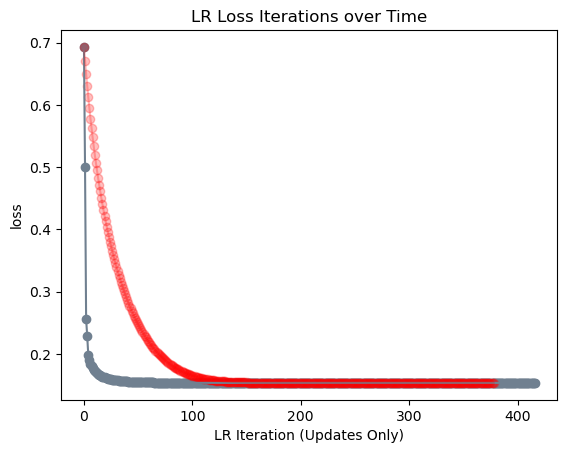

In [11]:
LR_grad, (loss_vec_grad, weight_vec_grad) = train_LR_Grad(X, y, 10, 0, 1000)
plot_loss(loss_vec_grad)

LR_new, (loss_vec_new, weight_vec_new) = train_LR_Newton(X, y, 10, 1000)
plot_loss(loss_vec_new, color="red", alpha=0.25)

## Part B: Experiments

#### Experiment 1:

Next, I ran an experiment to see the progression of the decision boundaries over time. By plotting the boundaries, we see weight convergence toward a boundary that seems to provide a possible best possible separation line considering linearly inseparable data.

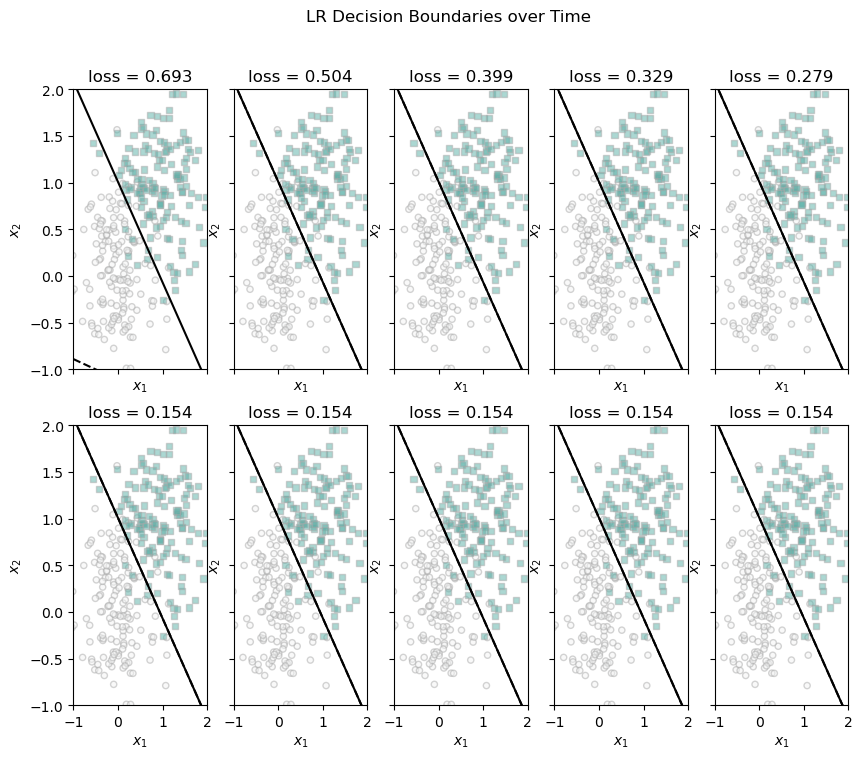

In [12]:
LR, (loss_vec, weight_vec) = train_LR_Newton(X, y, 100, 1000)
plot_decisions(X, y, weight_vec, loss_vec)

#### Experiment 2:

After this, I tested for convergence of the Newton optimizer at a faster rate than the standard gradient descent optimizer. With an α value of 100, I found that my model converged in ~40 steps compared to the standard optimizer's ~400 steps.

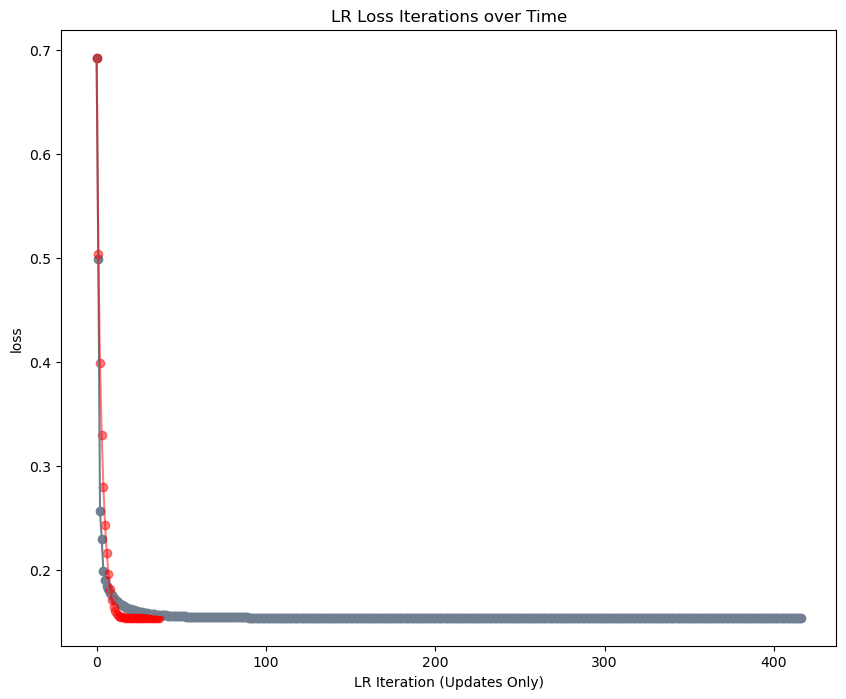

In [13]:
LR_grad, (loss_vec_grad, weight_vec_grad) = train_LR_Grad(X, y, 10, 0, 1000)
plot_loss(loss_vec_grad)

LR, (loss_vec, weight_vec) = train_LR_Newton(X, y, 100, 1000)
plot_loss(loss_vec, color="red", alpha=0.5)

#### Experiment 3:

Finally, I tried to find an α value where the model does not converge. This occurred when an inversion could no longer occur on the hessian matrix at an α value of 1000.

In [37]:
LR_new, (loss_vec_new, weight_vec_new) = train_LR_Newton(X, y, 1000, 1000)

_LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

We can see this loss increase over time by plotting its first few points. Here, the iterations that don't have points indicate a loss value of nan. The increase of loss (alongside the above error message) implies a divergence of the model's parameters:

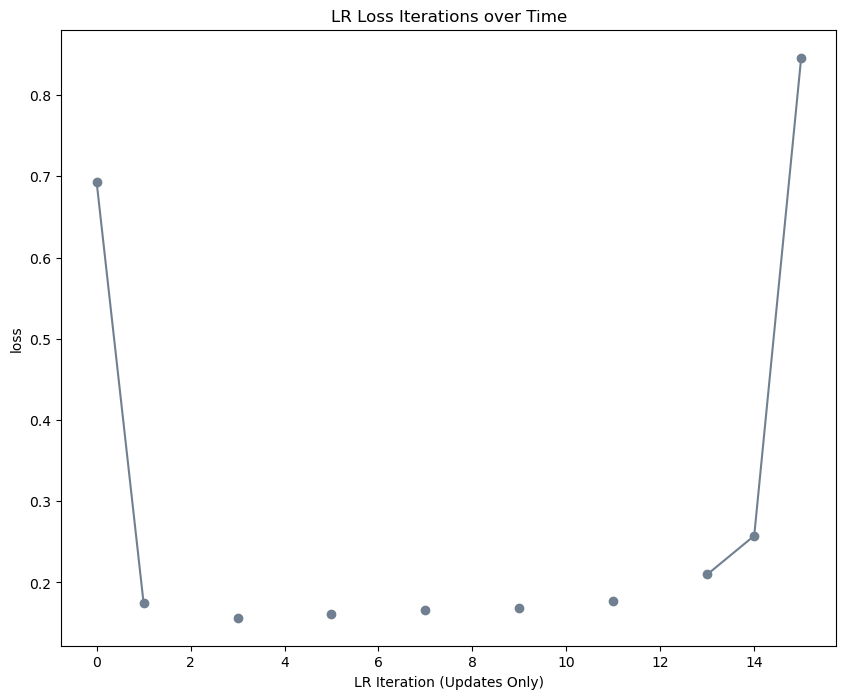

In [39]:
plot_loss(loss_vec_new[0:17])

## Part C: Operation Counting

To compare the two optimizers in terms of computation units, we need to make assumptions about the different steps of each optimizer. Computing the loss costs $c$ units, gradient computation costs $2c$, Hessian computation costs $pc$ units, the inversion of a $p x p$ matrix costs $k_1p^γ$ units (where $2 \le γ \le 3$), and the Newton method's matrix-vector multiplication costs $k_2p^2$ units.

#### Newton's Method
One call of the Newton step function includes a call to gradient, a computation of the Hessian, an inversion of the matrix, and a matrix-vector multiplication. As such:

model.step = $2c + pc + k_2p^2 + k_1p^γ = (2+p)c + k_2p^2 + k_1p^γ$

Adding the call to loss in one step of the training loop, we get:

$t_0 = (3+p)c + k_2p^2 + k_1p^γ$

And accounting for the full training loop of length $t_{nm}$:

$t_s = t_{nm}((3+p)c + k_2p^2 + k_1p^γ)$

#### Gradient Descent Optimizer

For the gradient descent optimizer, one training step calls one instance of the gradient function and one instance of the loss function:

$t_0 = 2c + c = 3c$

As such, the full training loop of length $t_{gd}$ would be:

$t_s = t_{gd}3c$

Comparing the inequalities, we can reduce to see the case where the Newton's method requires fewer computations to complete:

$t_{nm}(3c + pc + k_2p^2 + k_1p^γ) < 3ct_{gd}$

<!-- $t_{nm} < \frac{t_{gd}}{pc + k_2p^2 + k_1p^γ}$ -->
$t_{nm}(pc + k_2p^2 + k_1p^γ) < t_{gd}$

Thus, when $t_{nm}(pc + k_2p^2 + k_1p^γ) < t_{gd}$, Newton's method will require fewer computational units to complete compared to the standard method. When p is very high, then it becomes extremely hard for Newton's method to require fewer computational units. If $p = 100$, then the amount of computational units for one timestep will equal $100c + 10000k_2 + 100^γk_1$ units, meaning $t_{gd}$ will need to be units of magnitude higher for Newton's method to be worth it computationally.

## Conclusion

In the course of this blog post, I found that Newton's optimizer can be made to converge similar to the standard gradient descent optimizer. Further, at specific α values, the Newton optimizer converges in many fewer training steps compared to the standard optimizer. However, at specific α values and very high dimensional values, Newton's optimizer becomes extremely unusable or inefficient. In the process of this blog post, I learned about the creation of Hessian matrices (and Newton's optimizer steps), using torch's functions for inversion and diagonalization. I also learned about when to use specific optimizers based on dimensionality.